 ## Motifs/Discords
Analyze the dataset for finding motifs and/or anomalies. Visualize and discuss them and their relationship with shapelets.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
from collections import defaultdict

from matrixprofile import *

In [3]:
def load_npy(filename):
    return np.load(filename)

# reload 
X_y_ids = load_npy(r'C:\Users\HUAWEI\Desktop\DM2\project NEW\output_data\X_y_ids.npz') 
X, y, ids = X_y_ids['arr_0'], X_y_ids['arr_1'], X_y_ids['arr_2']

In [4]:
#per trasformare in dataframe

df = pd.DataFrame(np.squeeze(X))
df["genre"] = y
df.shape

(10000, 1281)

In [5]:
a = ['happy','piano']
df_filtered = df[df['genre'].isin(a)] 
df_filtered.shape

(1000, 1281)

In [8]:
# Assegna la variabile target
y = df_filtered.iloc[:, -1].values

# Assegna il resto dei valori a X escludendo l'ultima colonna
X = df_filtered.iloc[:, :-1].values
X.shape, y.shape

((1000, 1280), (1000,))

In [9]:
from sklearn.preprocessing import LabelEncoder

# Inizializza e addestra il LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [10]:
from tslearn.clustering import TimeSeriesKMeans
from tslearn.utils import to_time_series_dataset
import numpy as np
from tslearn.metrics import dtw


# Definiamo il numero di classi di genere musicale
num_classi = 2

# Inizializziamo un dizionario per memorizzare i centroidi per ciascuna classe di genere musicale
centroidi_per_classe = {}

# Convertiamo le serie temporali in un formato compatibile con tslearn
#X = to_time_series_dataset(X)

# Dividiamo il dataset in subset per ogni classe di genere musicale
for classe in range(num_classi):
    subset_X = X[y_encoded == classe]  # Seleziona solo le serie temporali appartenenti alla classe corrente
    kmeans = TimeSeriesKMeans(n_clusters=1, metric= "euclidean", verbose=0, random_state=42).fit(subset_X)  # Esegui TimeSeriesKMeans con k=1
    centroidi_per_classe[classe] = kmeans.cluster_centers_[0]  # Salva il centroide per la classe corrente

In [13]:
centroidi_per_classe

{0: array([[2997.19839046],
        [2978.42941568],
        [2970.81105579],
        ...,
        [2854.73276492],
        [2839.3016486 ],
        [2801.58333856]]),
 1: array([[925.99570759],
        [941.19267866],
        [965.6552027 ],
        ...,
        [955.3910824 ],
        [951.40904176],
        [932.4140462 ]])}

In [14]:
c0 = centroidi_per_classe[0]
c1 = centroidi_per_classe[1]

In [23]:
centr = np.array([c0,c1])
centr = centr.squeeze()
centr.shape

(2, 1280)

In [15]:
from scipy.spatial.distance import cdist
from fastdtw import fastdtw
from pyts.approximation import DiscreteFourierTransform
from tslearn.clustering import silhouette_score 


# Get the centroids
def getNearestTS(data, centroids):
    centroids = np.squeeze(centroids)

    # Function to calculate DTW distance between two time series
    def dtw_distance(ts1, ts2):
        distance, _ = fastdtw(ts1, ts2)
        return distance

    # Calculate the distance between each centroid and all time series data points
    distances = cdist(centroids, data, metric=dtw_distance) #euclidean?

    # Find the nearest time series for each centroid
    nearest_indices = np.argmin(distances, axis=1)

    # Retrieve the nearest time series for each centroid
    #nearest_time_series = [x_train_dft[i] for i in nearest_indices]

    # Print the results
    for i, centroid in enumerate(centroids):
        print (f"Centroid {i}: Nearest Time Series Index = {nearest_indices[i]}")

In [24]:
# 4 minuti

# X è array bidimensionale delle due classi
# centr è array bidimensionale dei due centroidi delle classi ottenuto da kmeans

getNearestTS(X,centr)


Centroid 0: Nearest Time Series Index = 474
Centroid 1: Nearest Time Series Index = 345


In [ ]:
def moving_average_smoothing(series, window_size):
    """
    Perform moving average smoothing on a single time series.
    
    series: Input time series as a 1-dimensional numpy array.
    window_size: Size of the moving window as an integer.
    
    Returns the smoothed time series.
    """
    window = np.ones(window_size) / window_size
    smoothed_series = np.convolve(series, window, mode='same')
    return smoothed_series


X_app = X.copy()

w = 10 
for i,time_series in enumerate(X_app):
    X_app[i]= moving_average_smoothing(X_app[i], w)

<function matplotlib.pyplot.show(close=None, block=None)>

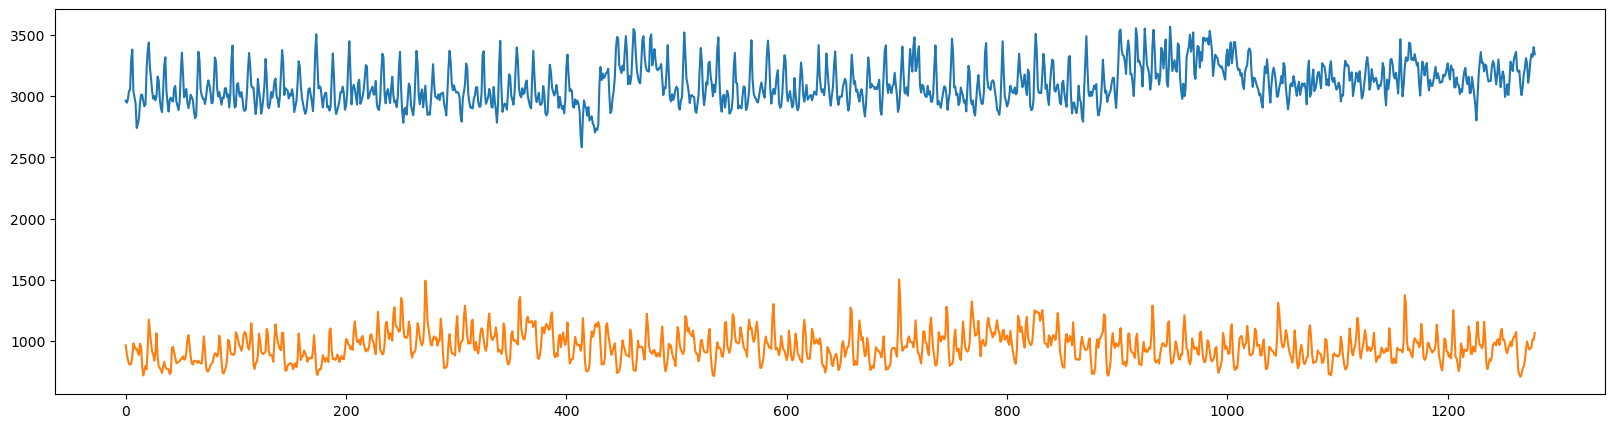

In [67]:
#plotto

ts0 = X[474]
ts1 = X[345]

# ts0 = X_app[474]
# ts1 = X_app[345]

plt.figure(figsize=(20,5))
plt.plot(ts0)
plt.plot(ts1)
plt.show

adesso con X smothed e approssimato

In [32]:
from pyts.approximation import PiecewiseAggregateApproximation

window_size = 4

paa = PiecewiseAggregateApproximation(window_size=window_size)
X_paa = paa.transform(X_app)
X_paa.shape


(1000, 320)

<function matplotlib.pyplot.show(close=None, block=None)>

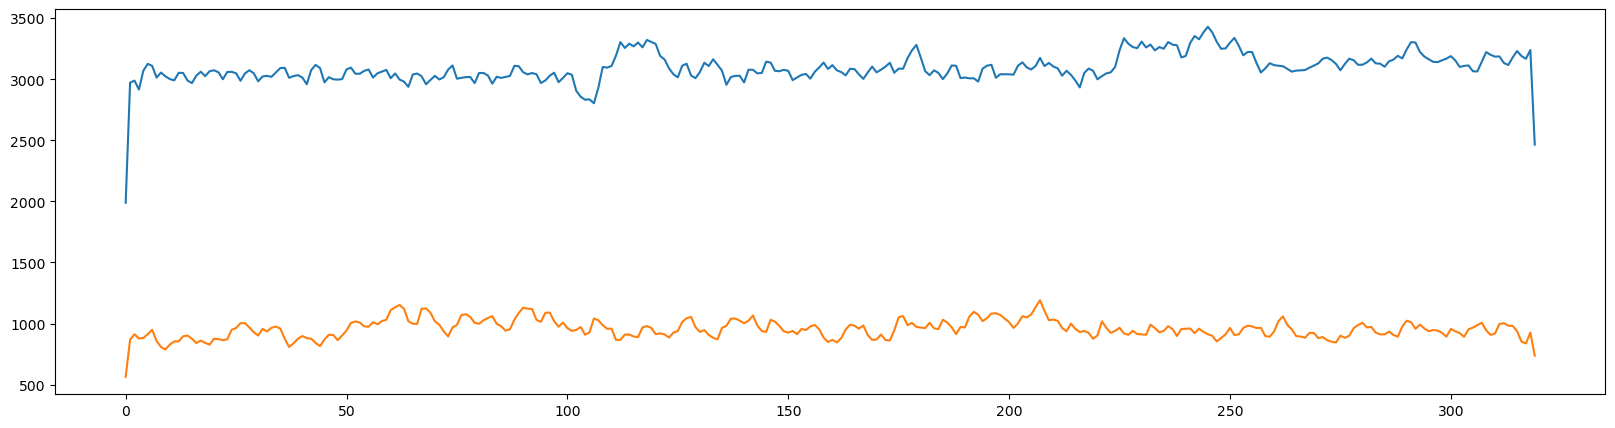

In [48]:
#plotto
ts0_paa = X_paa[474]
ts1_paa = X_paa[345]

plt.figure(figsize=(20,5))
plt.plot(ts0_paa)
plt.plot(ts1_paa)
plt.show

## Matrix Profile

Le time series sulle quali andiamo a lavorare sono le seguenti:

- Centroid 0: Nearest Time Series Index = 474
- Centroid 1: Nearest Time Series Index = 345

lavoro prima su dataset originale: ts0 e ts1\
e poi su smothed e app: ts0_paa e ts1_paa

### Inizio a fare delle prove considerando diverse size per le finestre (w): 

La funzione `pd.Series()` in Pandas viene utilizzata per creare un oggetto di tipo Series. Un oggetto Series è un array unidimensionale etichettato, in cui possono essere memorizzati dati di tipo omogeneo o eterogeneo. Può essere pensato come una struttura dati simile a un array o a una lista in Python, ma con l'aggiunta di etichette o indici che possono essere utilizzati per accedere ai valori.

Nel tuo esempio, `ts3` sembra essere un qualche tipo di dato, forse una lista o un array, e `pd.Series(ts3)` sta creando un oggetto Series a partire da questo dato. Questo può essere utile per svolgere operazioni specifiche su dati strutturati, come ad esempio l'analisi dei dati temporali o l'esecuzione di operazioni statistiche.

In [227]:
# trasformo serie da numpy array a Series (formato come quello di Guidotti per semplificare i grafici)
#prova con ts0

tsX = pd.Series(ts1)
tsX

0        967.044499
1        902.616481
2        850.382046
3        816.736079
4        808.692627
           ...     
1275     942.475285
1276     949.089403
1277    1015.086632
1278    1010.942789
1279    1066.805518
Length: 1280, dtype: float64

### W-PICCOLISSIME DIMENSIONI = 10, 25, 50, 75

In sintesi, questo codice calcola il profilo della matrice per la serie temporale tsX, ne traccia il risultato e identifica i motivi all'interno della serie temporale.\
 mp sarà il profilo della matrice risultante, mentre mpi sarà l'indice associato a ciascun valore nel profilo della matrice.

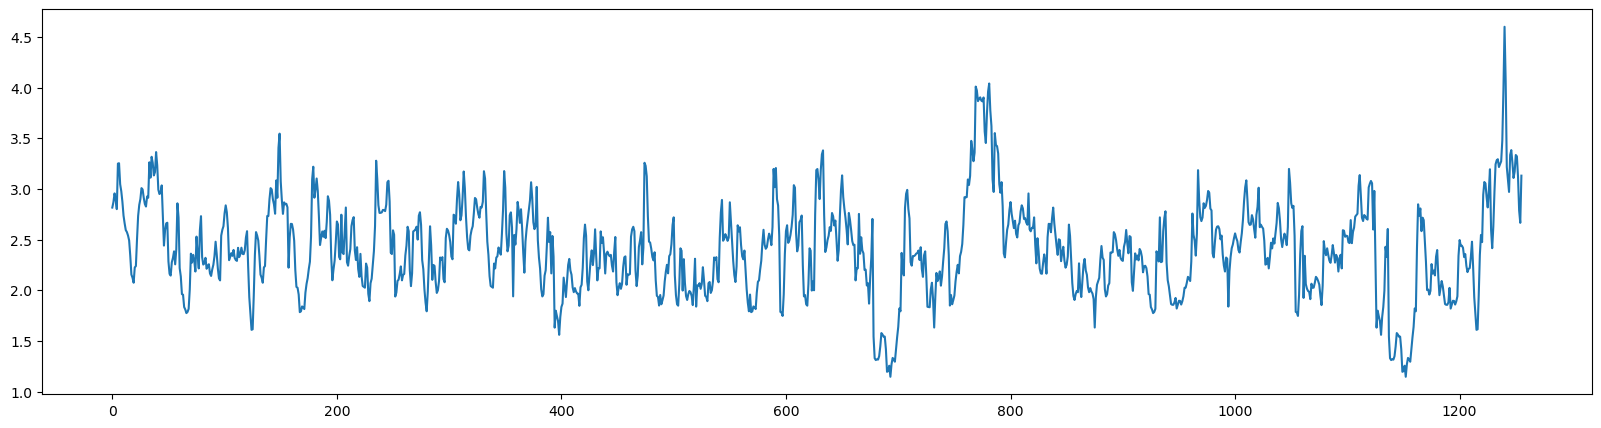

([[176, 693, 1152],
  [162, 334, 679, 1138],
  [68,
   111,
   212,
   369,
   384,
   398,
   441,
   512,
   556,
   714,
   728,
   829,
   843,
   857,
   886,
   900,
   1072,
   1173,
   1188,
   1216],
  [9, 96, 124, 239, 296, 318, 353, 497, 612, 654, 985, 1014],
  [482, 597, 913, 942, 1056],
  [52, 267, 281, 468, 583, 927, 956, 998],
  [24, 82, 225, 253, 454, 526, 569, 741, 870, 1028, 1085, 1099, 1201],
  [424, 625, 970],
  [196, 540, 756, 778, 814, 1114]],
 [1.145575262681667,
  1.3289286077910172,
  1.5596106543219221,
  1.6090008958884616,
  1.7458713988650225,
  1.7740064666973274,
  1.7834596964387985,
  1.9993691280291348,
  2.078173815349149])

In [228]:
w = 25
mp, mpi = matrixProfile.stomp(tsX.values, w)

plt.figure(figsize=(20,5))
plt.plot(mp)
plt.show()
tsX

mo, mod  = motifs.motifs(tsX.values, (mp, mpi), max_motifs= 10)
mo,mod


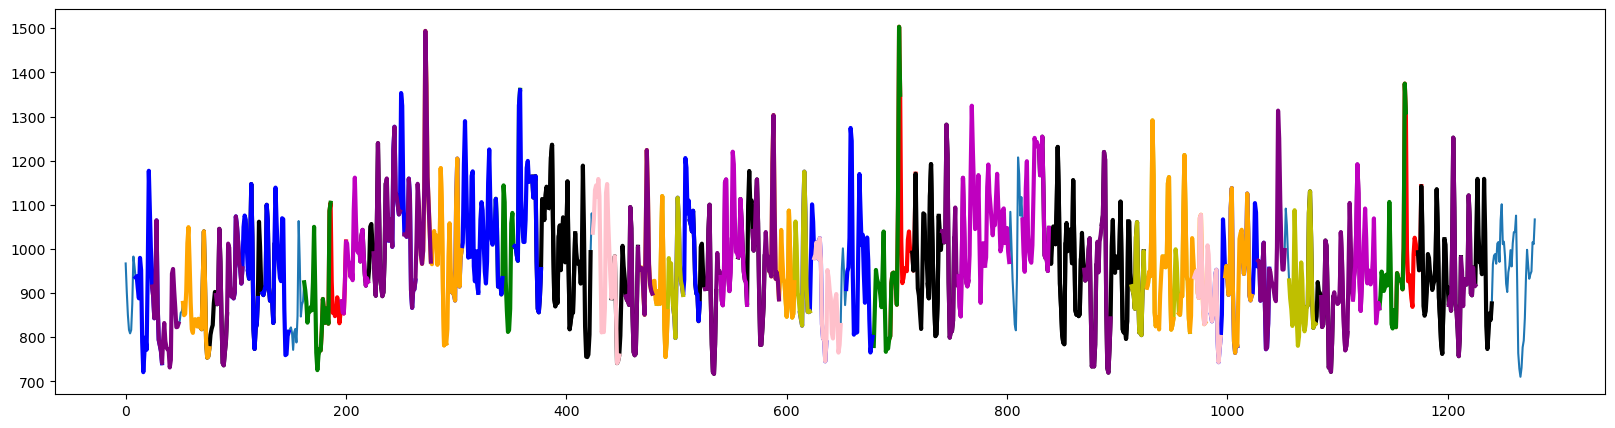

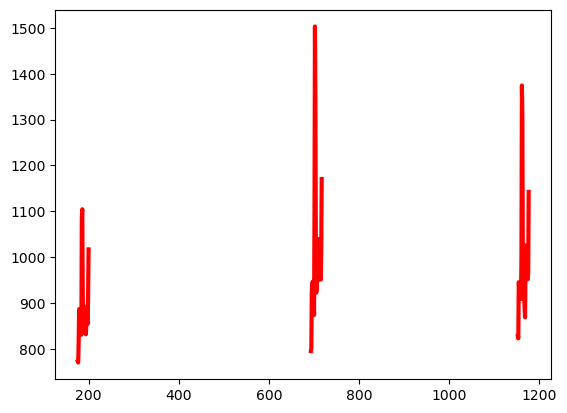

<Figure size 2000x500 with 0 Axes>

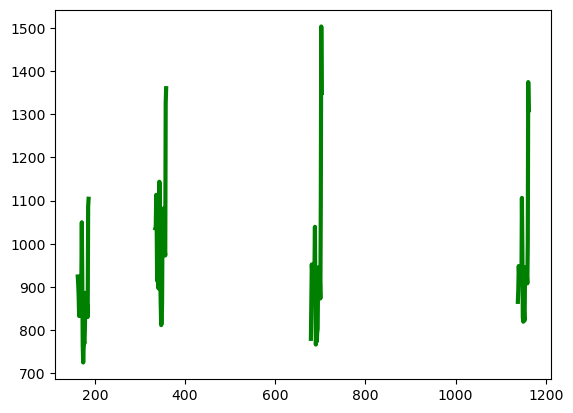

<Figure size 2000x500 with 0 Axes>

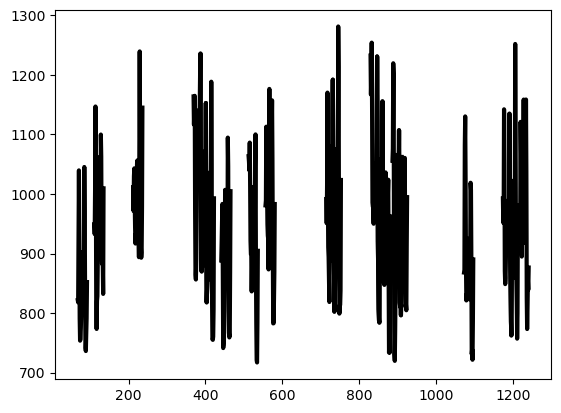

<Figure size 2000x500 with 0 Axes>

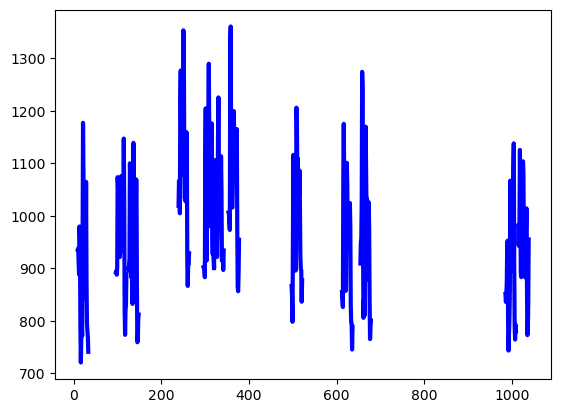

<Figure size 2000x500 with 0 Axes>

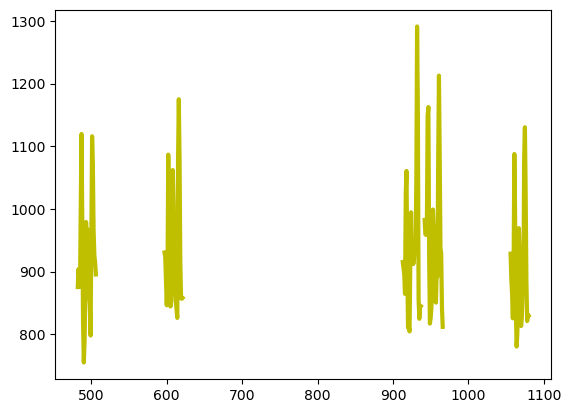

<Figure size 2000x500 with 0 Axes>

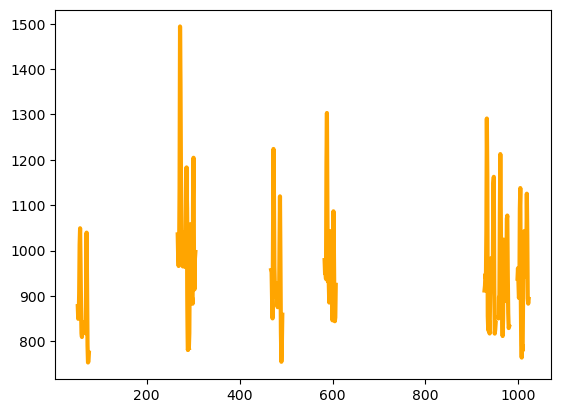

<Figure size 2000x500 with 0 Axes>

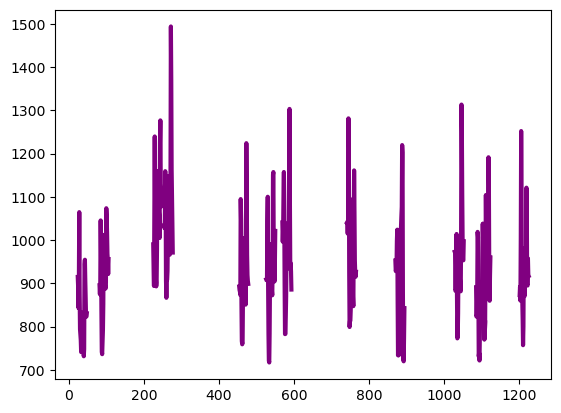

<Figure size 2000x500 with 0 Axes>

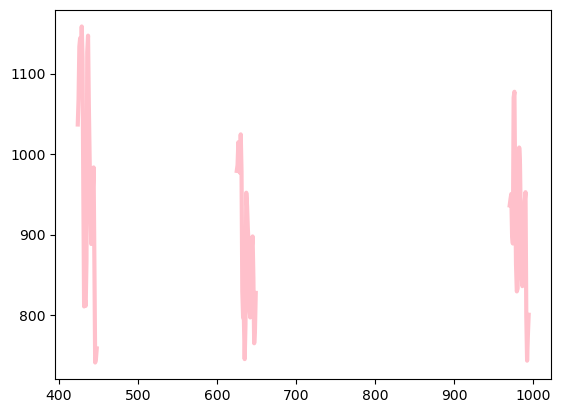

<Figure size 2000x500 with 0 Axes>

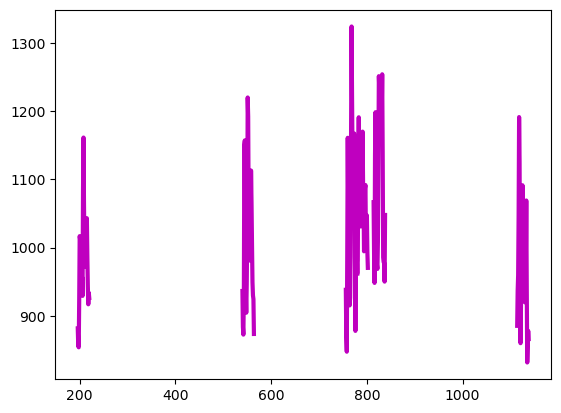

<Figure size 2000x500 with 0 Axes>

In [229]:
plt.figure(figsize=(20,5))
plt.plot(tsX.values)
colors = ['r', 'g', 'k', 'b', 'y', 'orange', 'purple', 'pink', 'm', 'c'][:len(mo)]   #sono 10
for m, d, c in zip(mo, mod, colors):
    for i in m:
        m_shape = tsX.values[i:i+w]
        plt.plot(range(i,i+w), m_shape, color=c, lw=3)

plt.show()

for m, d, c in zip(mo, mod, colors):
    for i in m:
        m_shape = tsX.values[i:i+w]
        plt.plot(range(i,i+w), m_shape, color=c, lw=3)
    plt.figure(figsize=(20,5))
    plt.show()

In [179]:
tsX = pd.Series(ts0)
tsX

0       2962.092431
1       2945.069137
2       2973.534077
3       3041.084470
4       3049.887456
           ...     
1275    3285.192751
1276    3340.669546
1277    3320.505662
1278    3398.636029
1279    3340.386204
Length: 1280, dtype: float64

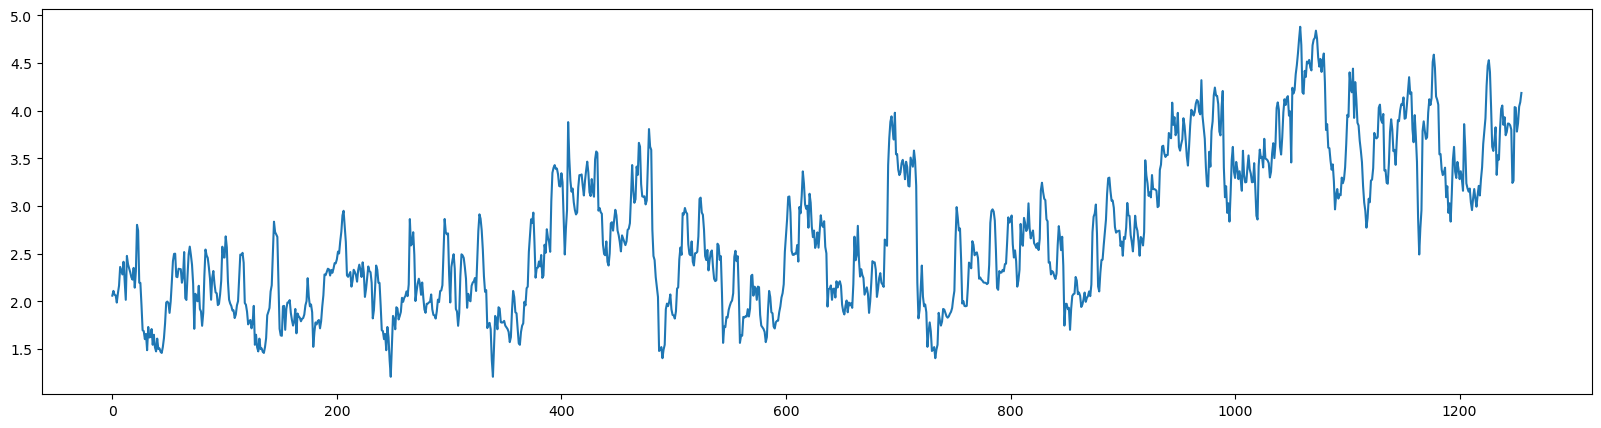

([[35, 126, 157, 187, 248, 339, 567, 643, 734, 856],
  [49, 95, 140, 216, 277, 384, 490, 536, 551, 581, 870],
  [74, 363, 667, 682, 834],
  [4, 19, 232, 308, 323, 460, 521, 597, 718, 764],
  [109, 170, 200, 261, 291, 443, 504, 747, 778, 808],
  [426, 624, 700, 791, 883, 898, 913, 928, 961, 1030, 1144, 1184],
  [403, 475, 977, 1004, 1081, 1164, 1199, 1233],
  [610, 945, 1055, 1123, 1212],
  [990, 1094, 1246]],
 [1.2085986142064085,
  1.403565881911158,
  1.5439801683337486,
  1.7434165991830337,
  1.824734036037392,
  2.301634832529066,
  2.4917519459001056,
  2.5911197967931074,
  3.1127776702969476])

In [188]:
w = 25
mp, mpi = matrixProfile.stomp(tsX.values, w)

plt.figure(figsize=(20,5))
plt.plot(mp)
plt.show()
tsX

mo, mod  = motifs.motifs(tsX.values, (mp, mpi), max_motifs= 10)
mo,mod

# ho sull'asse delle X solamente 50000 valori perchè ho ristretto la finestra

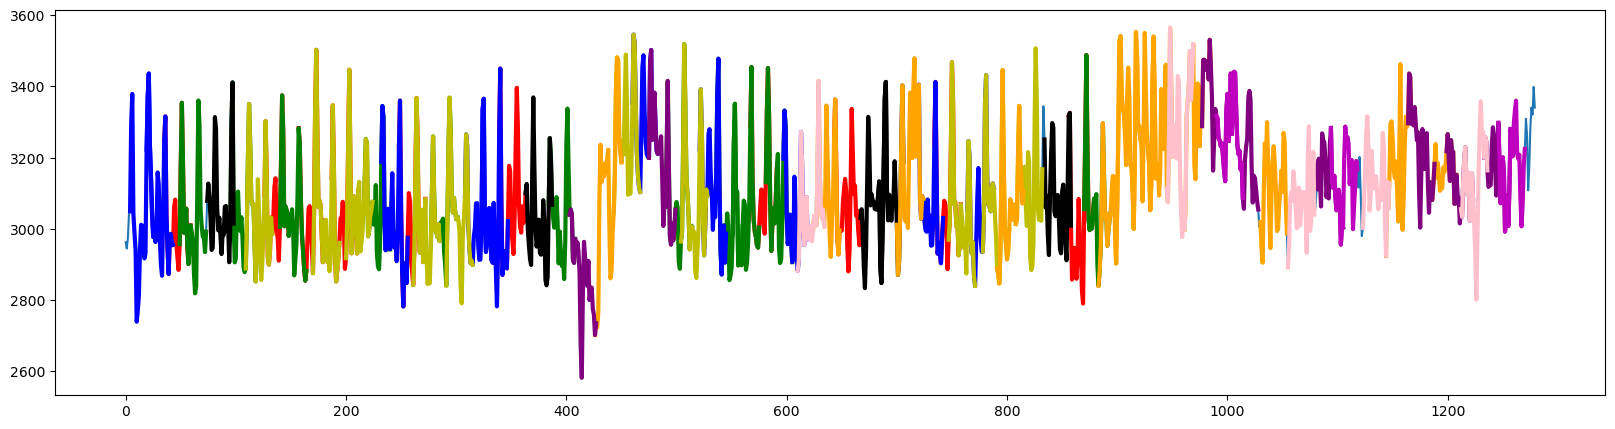

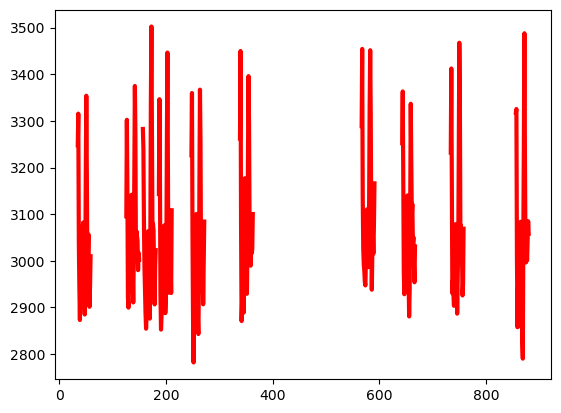

<Figure size 2000x500 with 0 Axes>

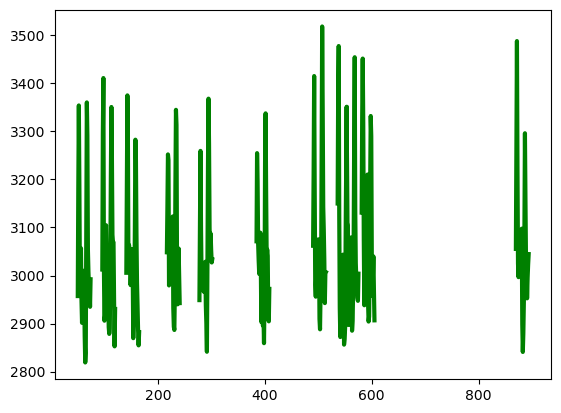

<Figure size 2000x500 with 0 Axes>

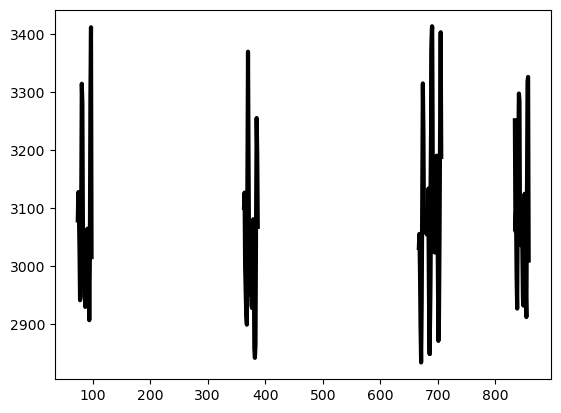

<Figure size 2000x500 with 0 Axes>

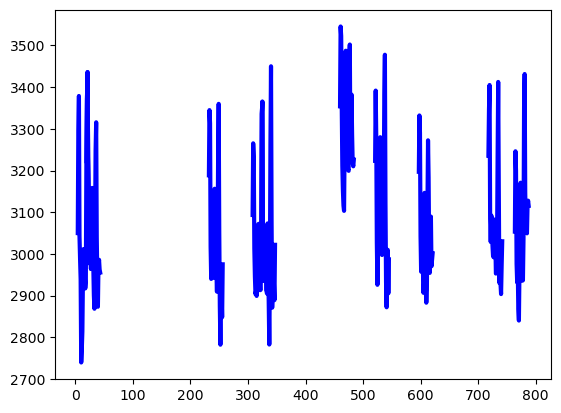

<Figure size 2000x500 with 0 Axes>

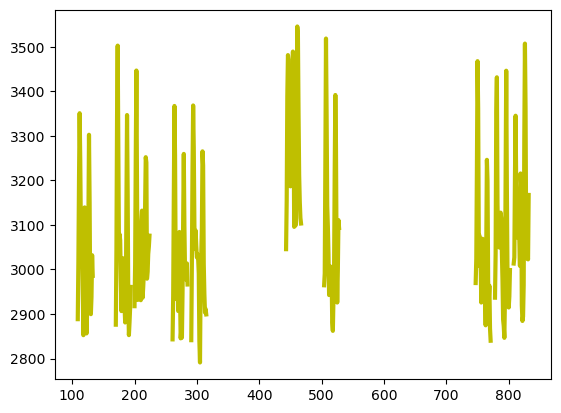

<Figure size 2000x500 with 0 Axes>

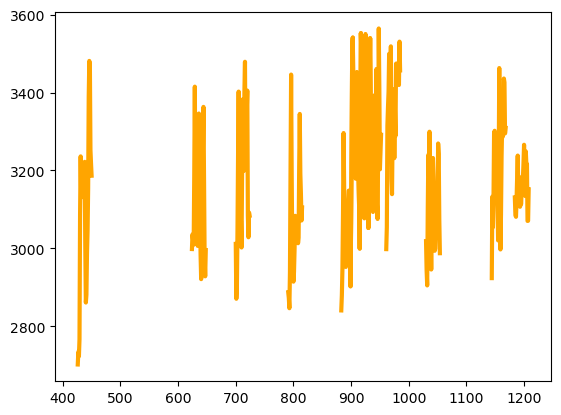

<Figure size 2000x500 with 0 Axes>

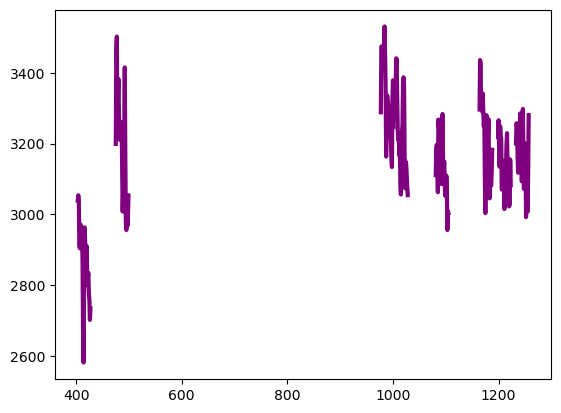

<Figure size 2000x500 with 0 Axes>

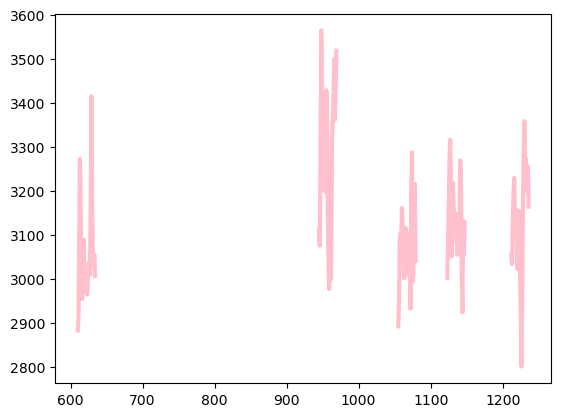

<Figure size 2000x500 with 0 Axes>

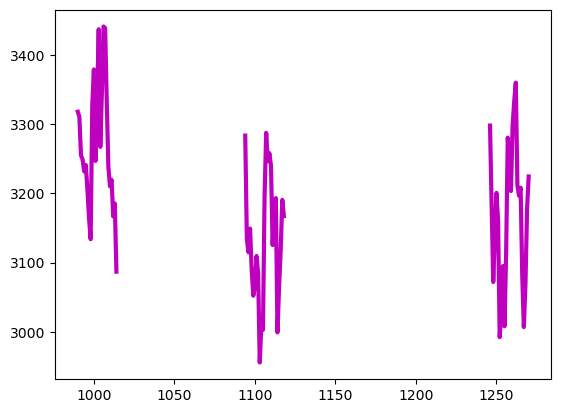

<Figure size 2000x500 with 0 Axes>

In [189]:
plt.figure(figsize=(20,5))
plt.plot(tsX.values)
colors = ['r', 'g', 'k', 'b', 'y', 'orange', 'purple', 'pink', 'm', 'c'][:len(mo)]
for m, d, c in zip(mo, mod, colors):
    for i in m:
        m_shape = tsX.values[i:i+w]
        plt.plot(range(i,i+w), m_shape, color=c, lw=3)

plt.show()

for m, d, c in zip(mo, mod, colors):
    for i in m:
        m_shape = tsX.values[i:i+w]
        plt.plot(range(i,i+w), m_shape, color=c, lw=3)
    plt.figure(figsize=(20,5))
    plt.show()

PAA

In [168]:
tsX_paa = pd.Series(ts1_paa)
tsX_paa

0      564.112471
1      866.975246
2      912.008925
3      877.198556
4      881.983433
          ...    
315    936.793822
316    851.590758
317    837.022974
318    926.075410
319    737.135154
Length: 320, dtype: float64

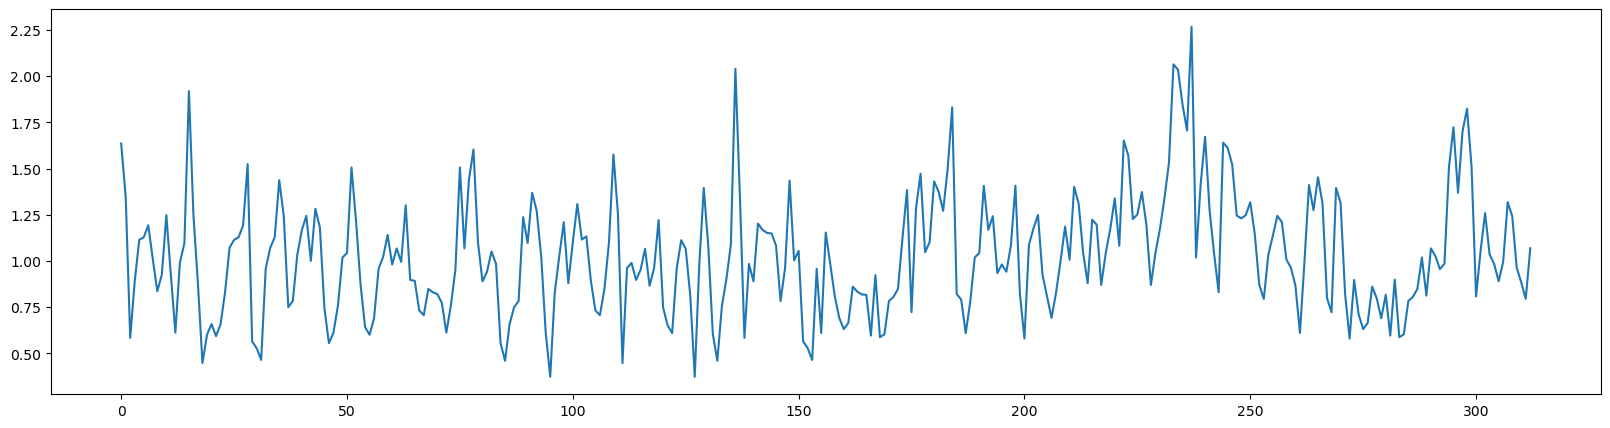

([[95, 127],
  [18, 54, 111],
  [47, 85, 132, 159],
  [31, 153],
  [200, 272],
  [2, 79, 138],
  [168, 283],
  [8, 72, 122, 187],
  [67, 117, 146, 261],
  [206, 213, 292]],
 [0.3736616322279187,
  0.4476715423673894,
  0.4600231179170367,
  0.46478912117903226,
  0.5804493861065324,
  0.5841207339663582,
  0.587621381302316,
  0.60974839937504,
  0.6105375231106378,
  0.6925140028374424])

In [171]:
#mp_adj = np.append(mp[0],np.zeros(m-1)+np.nan)

tsX = pd.Series(ts0)

w = 8
mp, mpi = matrixProfile.stomp(tsX_paa.values, w)

plt.figure(figsize=(20,5))
plt.plot(mp)
plt.show()
tsX_paa

mo, mod  = motifs.motifs(tsX_paa.values, (mp, mpi), max_motifs=10)
mo,mod

# ho sull'asse delle X solamente 50000 valori perchè ho ristretto la finestra

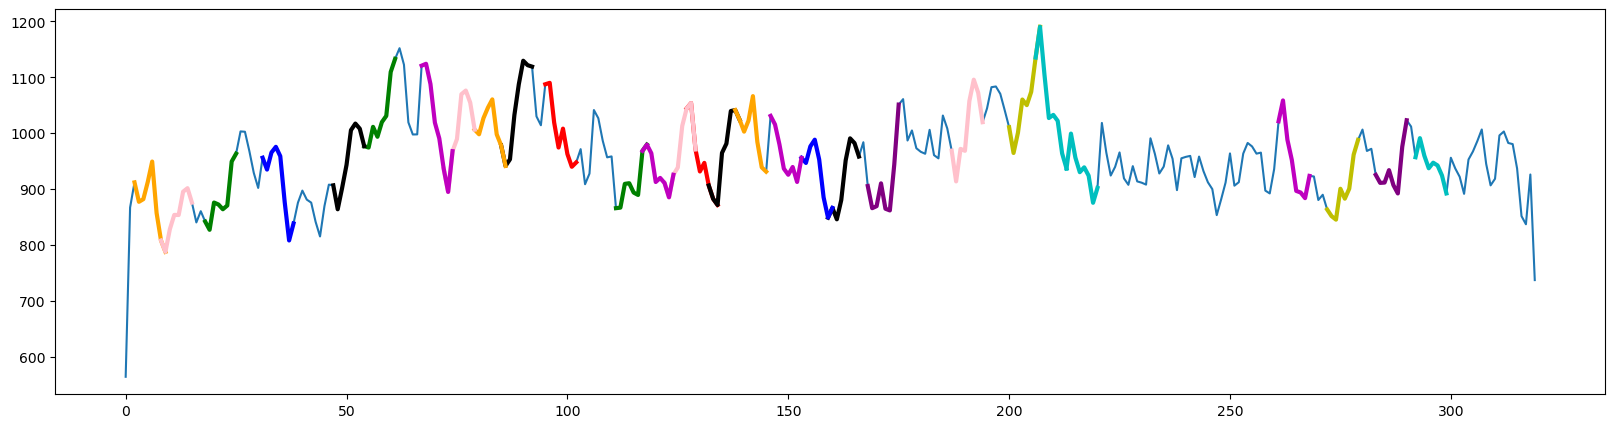

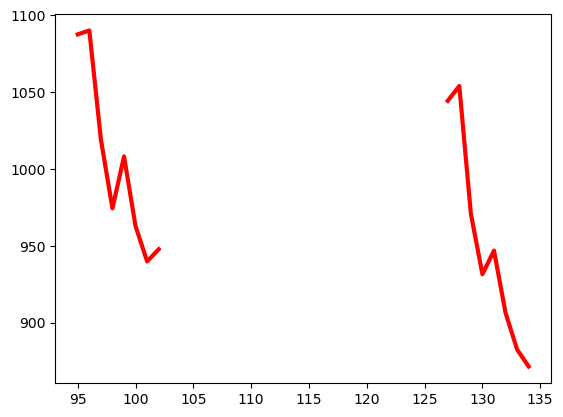

<Figure size 2000x500 with 0 Axes>

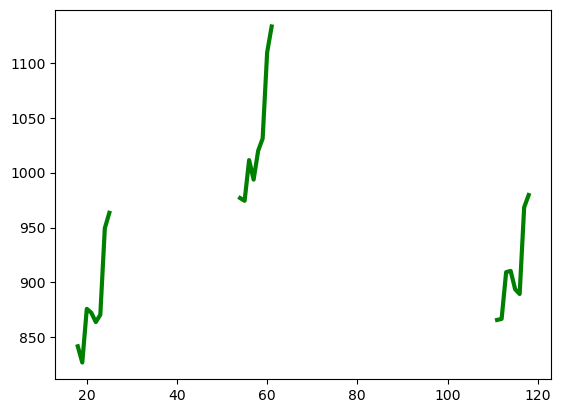

<Figure size 2000x500 with 0 Axes>

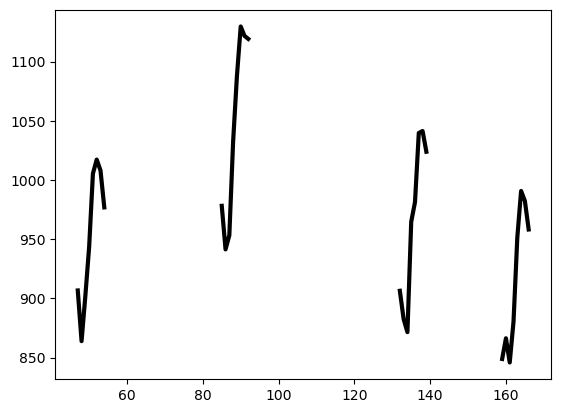

<Figure size 2000x500 with 0 Axes>

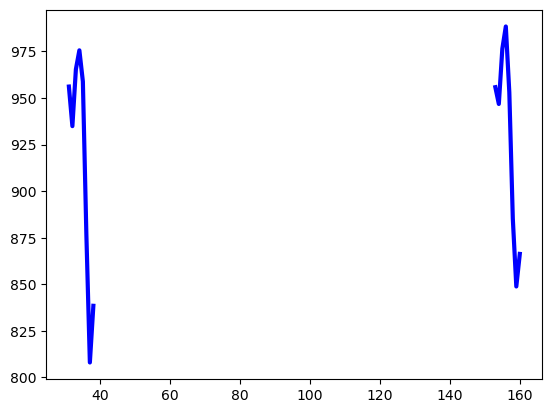

<Figure size 2000x500 with 0 Axes>

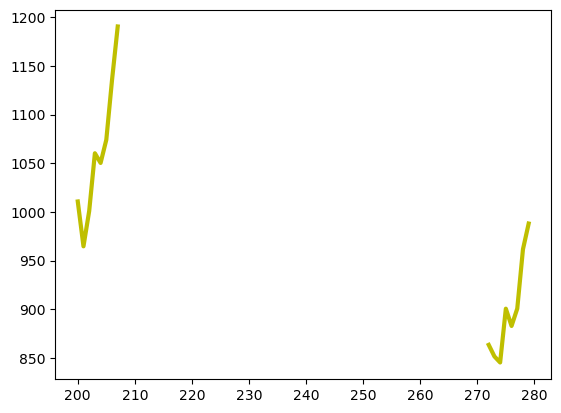

<Figure size 2000x500 with 0 Axes>

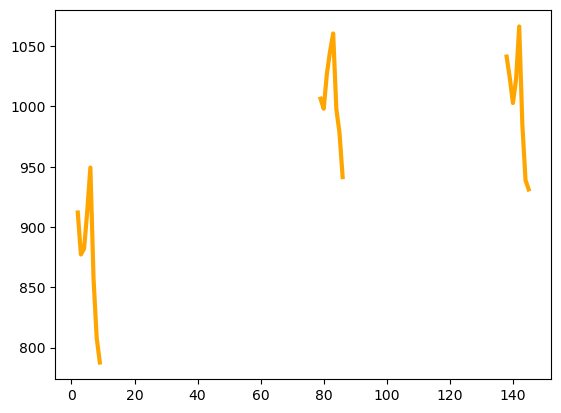

<Figure size 2000x500 with 0 Axes>

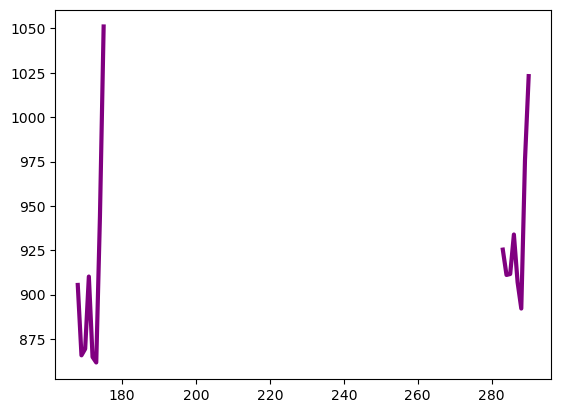

<Figure size 2000x500 with 0 Axes>

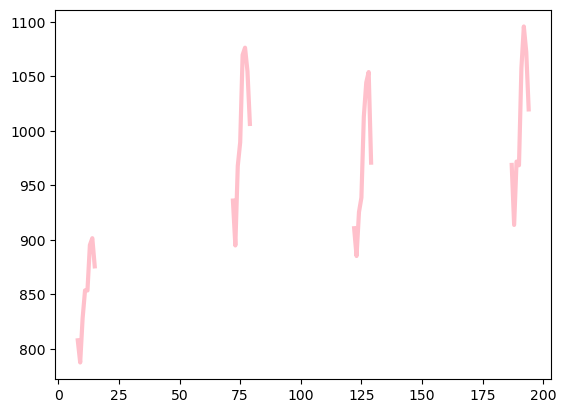

<Figure size 2000x500 with 0 Axes>

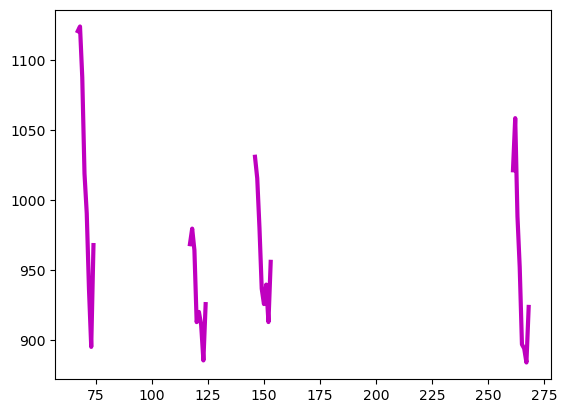

<Figure size 2000x500 with 0 Axes>

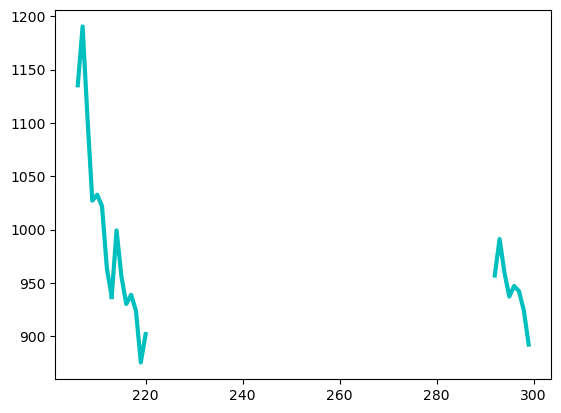

<Figure size 2000x500 with 0 Axes>

In [172]:
plt.figure(figsize=(20,5))
plt.plot(tsX_paa.values)
colors = ['r', 'g', 'k', 'b', 'y', 'orange', 'purple', 'pink', 'm', 'c'][:len(mo)]
for m, d, c in zip(mo, mod, colors):
    for i in m:
        m_shape = tsX_paa.values[i:i+w]
        plt.plot(range(i,i+w), m_shape, color=c, lw=3)

plt.show()

for m, d, c in zip(mo, mod, colors):
    for i in m:
        m_shape = tsX_paa.values[i:i+w]
        plt.plot(range(i,i+w), m_shape, color=c, lw=3)
    plt.figure(figsize=(20,5))
    plt.show()

In [173]:
tsX_paa = pd.Series(ts0_paa)
tsX_paa

0      1989.289915
1      2972.591316
2      2989.513914
3      2916.332367
4      3070.560921
          ...     
315    3231.869250
316    3190.401658
317    3167.928623
318    3240.008188
319    2465.011485
Length: 320, dtype: float64

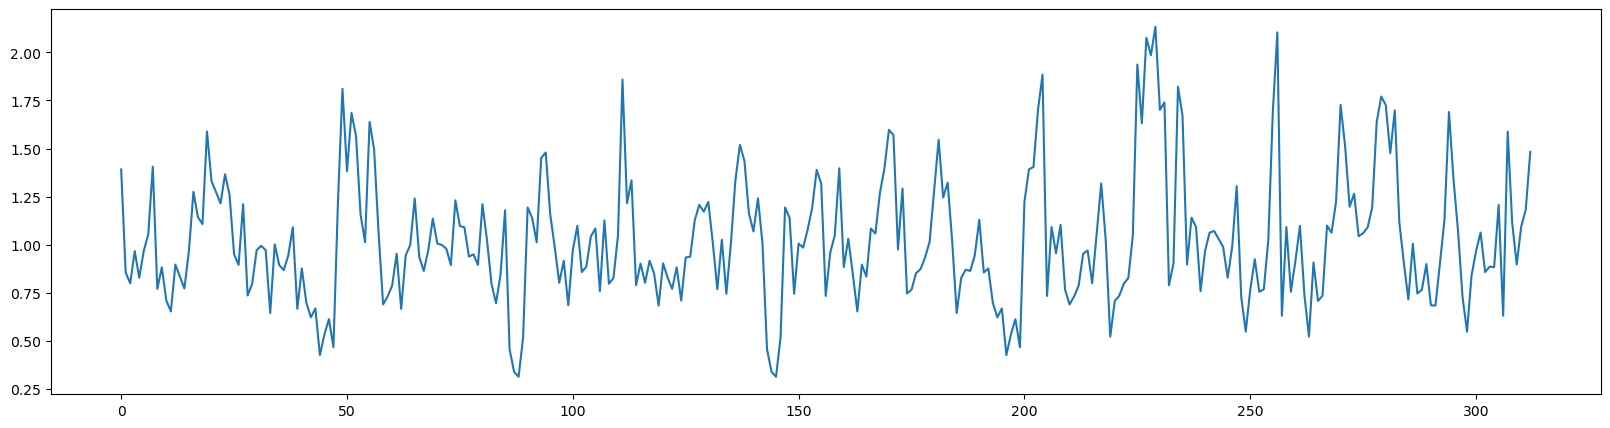

([[88, 145],
  [44, 196],
  [67, 219, 263, 284],
  [249, 298],
  [257, 306],
  [33, 185],
  [11, 125, 163, 276],
  [39, 62, 77, 191, 214],
  [5, 100, 119, 291],
  [83, 107, 140, 152]],
 [0.3139000880364778,
  0.4264686574316845,
  0.5224655920499535,
  0.5484513466148722,
  0.6311357437498406,
  0.6452720848843344,
  0.6533807563185725,
  0.6665758317778346,
  0.6837432478645642,
  0.6961911086483398])

In [174]:
w = 8
mp, mpi = matrixProfile.stomp(tsX_paa.values, w)

plt.figure(figsize=(20,5))
plt.plot(mp)
plt.show()
tsX_paa

mo, mod  = motifs.motifs(tsX_paa.values, (mp, mpi), max_motifs=10)
mo,mod


# ho sull'asse delle X solamente 50000 valori perchè ho ristretto la finestra

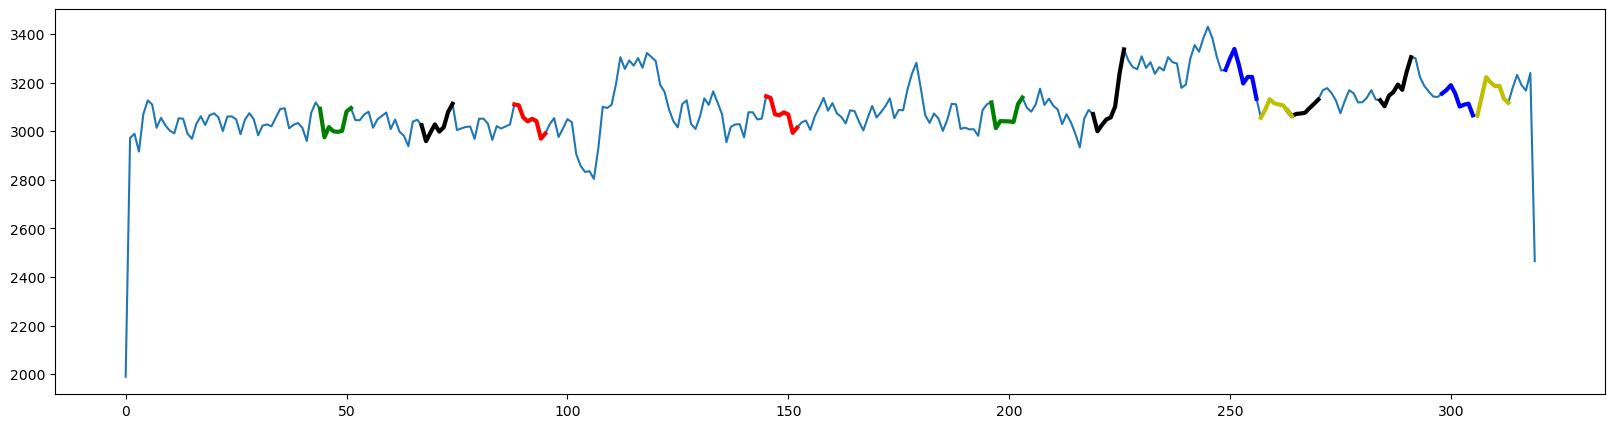

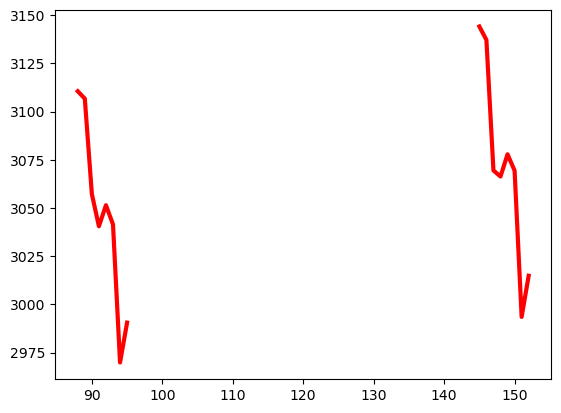

<Figure size 2000x500 with 0 Axes>

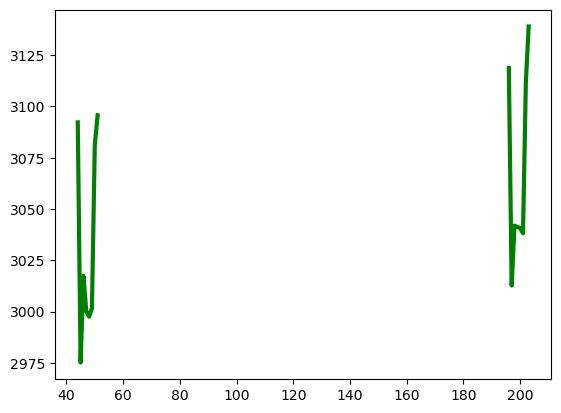

<Figure size 2000x500 with 0 Axes>

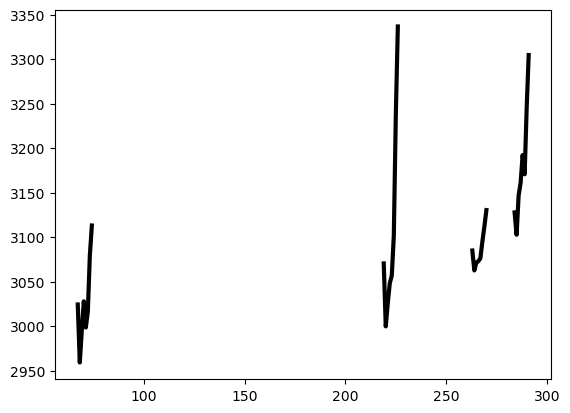

<Figure size 2000x500 with 0 Axes>

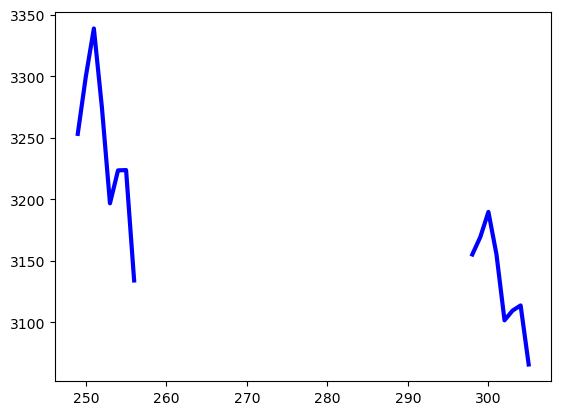

<Figure size 2000x500 with 0 Axes>

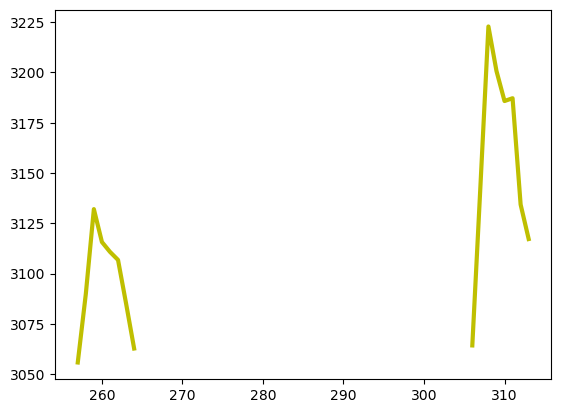

<Figure size 2000x500 with 0 Axes>

In [175]:
plt.figure(figsize=(20,5))
plt.plot(tsX_paa.values)
colors = ['r', 'g', 'k', 'b', 'y',][:len(mo)]
for m, d, c in zip(mo, mod, colors):
    for i in m:
        m_shape = tsX_paa.values[i:i+w]
        plt.plot(range(i,i+w), m_shape, color=c, lw=3)

plt.show()

for m, d, c in zip(mo, mod, colors):
    for i in m:
        m_shape = tsX_paa.values[i:i+w]
        plt.plot(range(i,i+w), m_shape, color=c, lw=3)
    plt.figure(figsize=(20,5))
    plt.show()

# Motif Discovery

In [194]:
#mp_adj = np.append(mp[0],np.zeros(m-1)+np.nan)

tsX = pd.Series(ts0)

mo, mod  = motifs.motifs(tsX.values, (mp, mpi), max_motifs=10)

Parameters
- max_motifs: stop finding new motifs once we have max_motifs
- radius: For each motif found, find neighbors that are within radius*motif_mp of the first.
- n_neighbors: number of neighbors from the first to find. If it is None, find all.
- ex_zone: minimum distance between indices for after each subsequence is identified. Defaults to m/2 where m is the subsequence length. If ex_zone = 0, only the found index is exclude, if ex_zone = 1 then if idx is found as a motif idx-1, idx, idx+1 are excluded.


Returns
The function returns a tuple (top_motifs, distances) which are lists of the same length.

- top_motifs: This is a list of the indices found for each motif. The first index is the nth motif followed by all nearest neighbors found sorted by distances.
- distances: Minimum Matrix profile value for each motif set.

In [123]:

mo

[[176, 263, 693, 1152],
 [399, 442, 672, 729, 1131, 1174],
 [0, 101, 129, 201, 301, 323, 358, 430, 516, 559, 861, 1220],
 [279, 379, 710, 839, 881, 896, 1082],
 [57, 157, 473],
 [229, 343, 458, 530, 573, 1032, 1103],
 [21, 623, 825],
 [585, 742, 929, 958, 1202],
 [82, 985, 1000, 1187]]

In [124]:
mod

[1.013334986820111,
 1.0901846492551601,
 1.1305666335852875,
 1.1570496231716472,
 1.1774826756603791,
 1.212198126106469,
 1.2470708150478016,
 1.3535214121395387,
 1.3641120291677884]

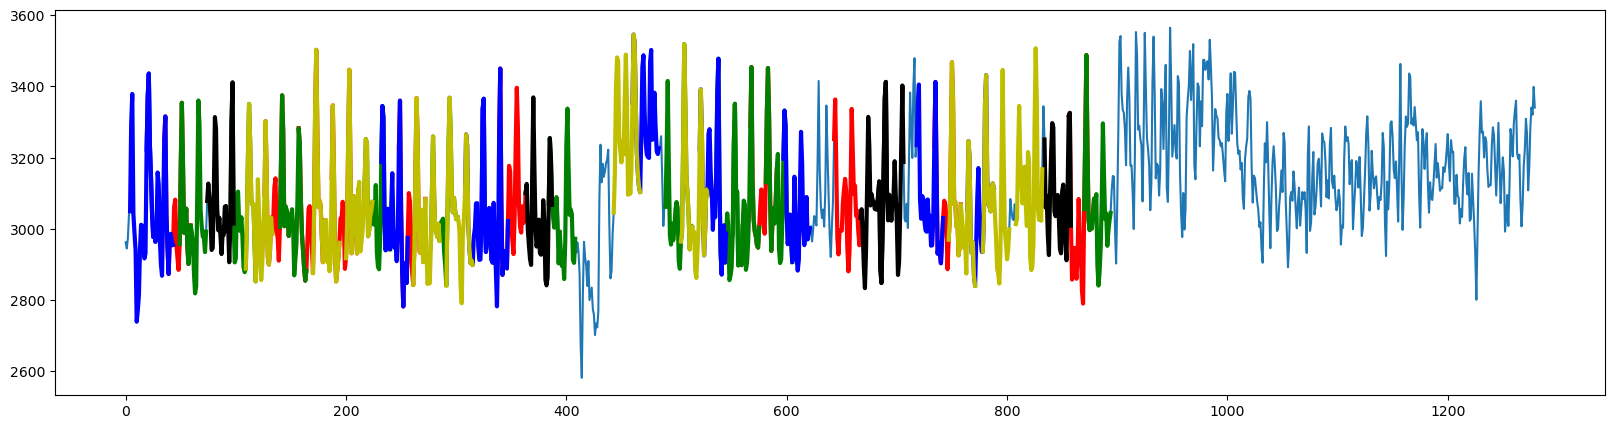

In [195]:
plt.figure(figsize=(20,5))

plt.plot(tsX.values)

colors = ['r', 'g', 'k', 'b', 'y'][:len(mo)]

for m, d, c in zip(mo, mod, colors):
    for i in m:
        m_shape = tsX.values[i:i+w]
        plt.plot(range(i,i+w), m_shape, color=c, lw=3)

plt.show()

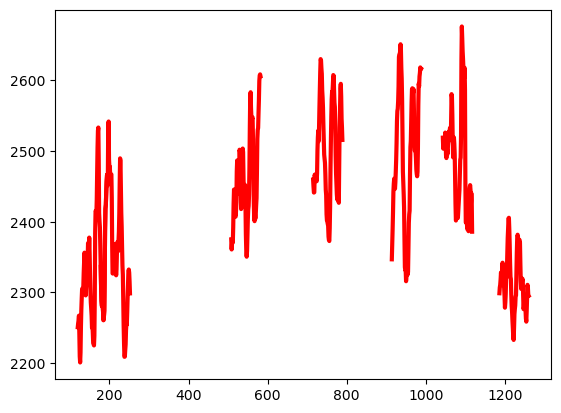

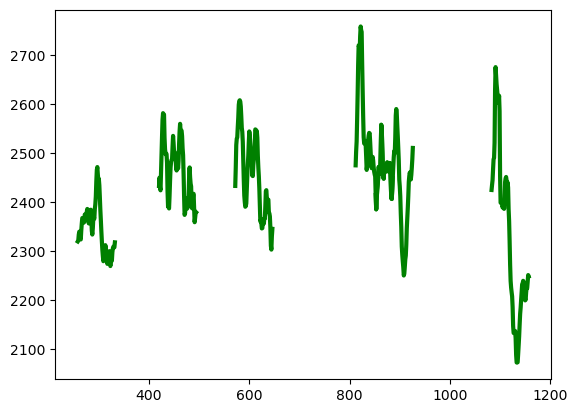

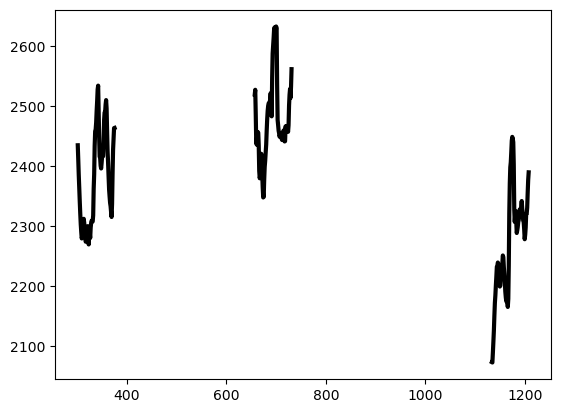

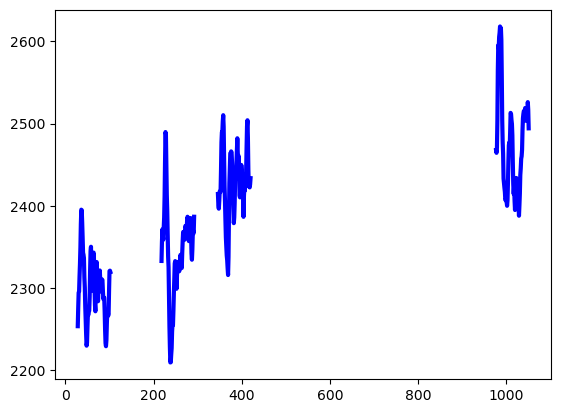

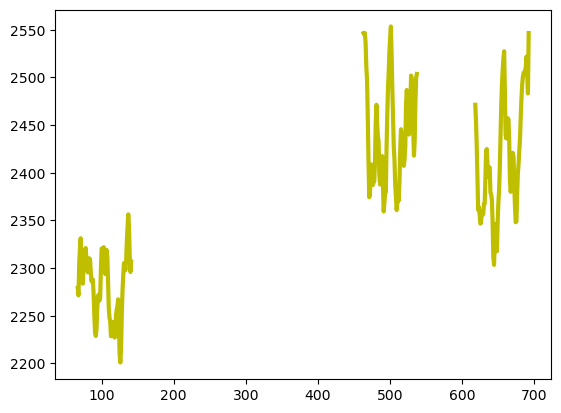

In [64]:
for m, d, c in zip(mo, mod, colors):
    for i in m:
        m_shape = tsX.values[i:i+w]
        plt.plot(range(i,i+w), m_shape, color=c, lw=3)
    plt.show()

# Anomaly Discovery

In [196]:
from matrixprofile.discords import discords

In [220]:
 
w = 25 #25
ts = ts1  #ts0 ts1 ts0_paa ts1_paa


tsX = pd.Series(ts)   
mp, mpi = matrixProfile.stomp(tsX.values, w)

mo, mod  = motifs.motifs(tsX.values, (mp, mpi), max_motifs=10)
mo,mod

([[176, 693, 1152],
  [162, 334, 679, 1138],
  [68,
   111,
   212,
   369,
   384,
   398,
   441,
   512,
   556,
   714,
   728,
   829,
   843,
   857,
   886,
   900,
   1072,
   1173,
   1188,
   1216],
  [9, 96, 124, 239, 296, 318, 353, 497, 612, 654, 985, 1014],
  [482, 597, 913, 942, 1056],
  [52, 267, 281, 468, 583, 927, 956, 998],
  [24, 82, 225, 253, 454, 526, 569, 741, 870, 1028, 1085, 1099, 1201],
  [424, 625, 970],
  [196, 540, 756, 778, 814, 1114]],
 [1.145575262681667,
  1.3289286077910172,
  1.5596106543219221,
  1.6090008958884616,
  1.7458713988650225,
  1.7740064666973274,
  1.7834596964387985,
  1.9993691280291348,
  2.078173815349149])

Parameters  
- mp: matrix profile numpy array
- k: the number of discords to discover
- ex_zone: the number of samples to exclude and set to Inf on either side of a found discord  

Returns 
 - a list of indexes represent the discord starting locations. MaxInt indicates there were no more discords that could be found due to too many exclusions or profile being too small. Discord start indices are sorted by highest matrix profile value.

In [221]:
anoms = discords(mp, ex_zone= 3, k=5)

In [222]:
anoms

array([1240,  781,  769,  773,  776])

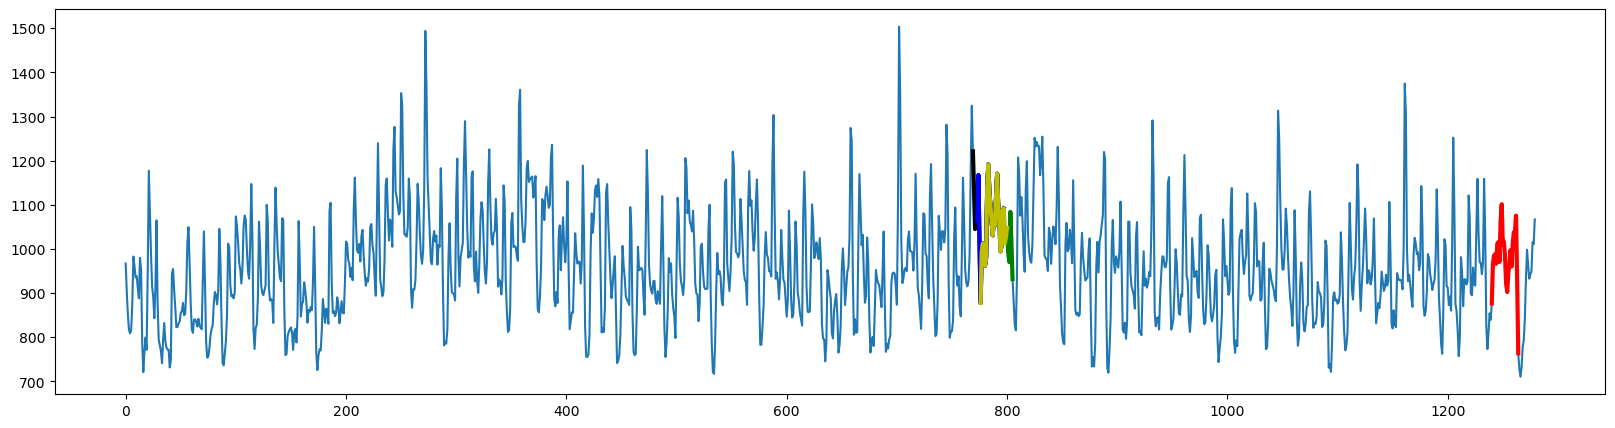

In [223]:
plt.figure(figsize=(20, 5))

plt.plot(tsX.values)
colors = ['r', 'g', 'k', 'b', 'y'][:len(mo)]
for a, c in zip(anoms, colors):
    a_shape = tsX.values[a:a+w]
    plt.plot(range(a, a+w), a_shape, color=c, lw=3)

plt.show()